In [173]:
import geopandas as gpd

from features.income import Income
from features.violence_calls import ViolenceCalls
from features.households import Households
from features.population import Population
from features.feature_constructor import Feature
from features.out_of_state_rental_ownership import OutOfStateRentalOwnership
from features.ddot_bus_stops import DDotBusStops
from features.project_green_light_locations import ProjectGreenlightLocations

from detroit_geos import get_detroit_census_geos, get_detroit_boundaries

import patsy
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Fetch geometries for visualization

In [110]:
tracts = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='tract',).set_index('geo_id')
detroit = get_detroit_boundaries()
block = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='block').set_index('geo_id')

# Build Features

In [ ]:
Ou

In [115]:
target_geo_grain = 'tract'

population = Population(decennial_census_year=2010,population_data_path='population',verbose=False)
# feat_population = population.construct_features(target_geo_grain)
# population.cache_features()
feat_population = population.load_cached_features(target_geo_grain)

call = ViolenceCalls(decennial_census_year=2010,verbose=False)
feat_call = call.load_cached_features(target_geo_grain)

income = Income(verbose=False)
feat_income = income.load_cached_features(target_geo_grain=target_geo_grain)

households = Households()
feat_households = households.load_cached_features(target_geo_grain)

feat_tuple = (feat_income,feat_households,feat_population,feat_call)
feat_df = pd.concat((feat_income,feat_households,feat_population,feat_call),axis=1)

In [167]:
feat_df.head()

,per_capita_income,per_household_income,households,married_families,non_family_households,population,violence_calls
tract,,,,,,,
2.616350e+10,3369.0,49015.0,1438,249,674,4032,2257.0
2.616350e+10,2834.0,61980.0,1088,190,370,3207,2334.0
2.616350e+10,1900.0,50345.0,811,61,491,3137,1948.0
2.616350e+10,1052.0,34880.0,375,45,140,1664,1030.0
2.616350e+10,1289.0,43058.0,506,61,274,2205,1450.0


[Text(0.5, 1.0, 'Violence-associated calls')]

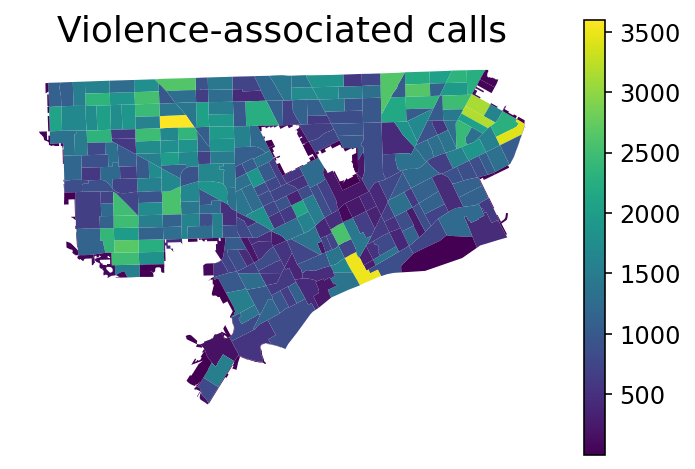

In [153]:
# fig, ax = plt.subplots(1,1,figsize=(15,7))
gpd.GeoDataFrame(pd.merge(feat_df.loc[:,['violence_calls']],tracts.geometry,left_index=True,right_index=True)).plot('violence_calls',legend=True)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
ax.set_frame_on(False)
ax.set(title='Violence-associated calls')

In [142]:
tracts.head()

,geometry,longitude,latitude
geo_id,,,
2.616350e+10,"POLYGON ((-82.95578 42.43558, -82.95580 42.436...",-82.951065,42.444180
2.616350e+10,"POLYGON ((-82.97099 42.44526, -82.97078 42.445...",-82.963043,42.446190
2.616350e+10,"POLYGON ((-82.97690 42.43628, -82.97648 42.436...",-82.965183,42.439028
2.616350e+10,"POLYGON ((-82.98668 42.42144, -82.98621 42.422...",-82.979006,42.426164
2.616350e+10,"POLYGON ((-82.97490 42.42227, -82.97493 42.423...",-82.967849,42.424141


In [121]:
df = feat_df.loc[lambda x: x.population > 5].assign(
    total_income=lambda x: x.households * x.per_household_income,
    new_per_capita_income=lambda x: x.total_income / x.population,
    calls_per_capita = lambda x: x.violence_calls/x.population,
    people_per_household = lambda x: x.population/x.households,
)

In [122]:
df.sort_values('people_per_household')

,per_capita_income,per_household_income,households,married_families,non_family_households,population,violence_calls,total_income,new_per_capita_income,calls_per_capita,people_per_household
tract,,,,,,,,,,,
2.616358e+10,3761.0,38262.0,1743,598,935,16,119.0,66690666.0,4.168167e+06,7.437500,0.009180
2.616358e+10,5246.0,43987.0,2049,524,982,58,5.0,90129363.0,1.553955e+06,0.086207,0.028306
2.616358e+10,5102.0,64732.0,1675,756,576,53,13.0,108426100.0,2.045775e+06,0.245283,0.031642
2.616355e+10,3598.0,73168.0,1254,459,376,87,12.0,91752672.0,1.054628e+06,0.137931,0.069378
2.616355e+10,2272.0,46674.0,840,185,345,63,10.0,39206160.0,6.223200e+05,0.158730,0.075000
...,...,...,...,...,...,...,...,...,...,...,...
2.616353e+10,904.0,32725.0,281,36,147,1425,657.0,9195725.0,6.453140e+03,0.461053,5.071174
2.616351e+10,2015.0,38953.0,285,92,99,3095,837.0,11101605.0,3.586948e+03,0.270436,10.859649
2.616352e+10,113.0,39956.0,48,19,22,1264,166.0,1917888.0,1.517316e+03,0.131329,26.333333


<AxesSubplot:>

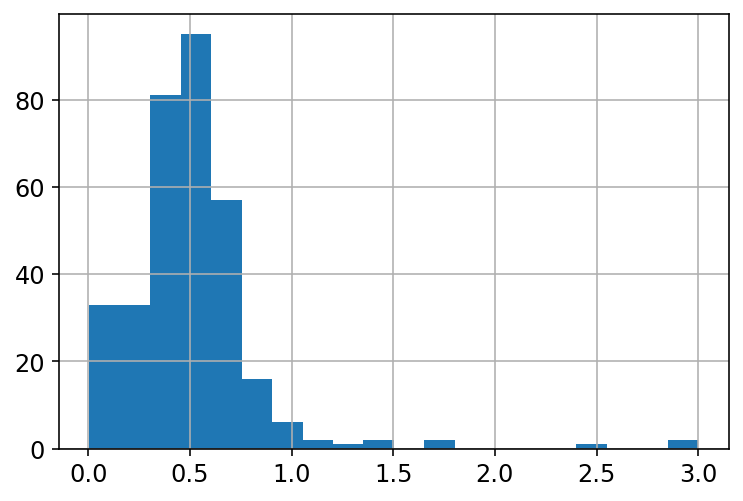

In [84]:
df.sort_values('calls_per_capita').calls_per_capita.clip(upper=3).hist(bins=20)

In [85]:
df.calls_per_capita.idxmax()

26163577000.0

In [88]:
tracts.head()

,geometry,longitude,latitude
geo_id,,,
2.616350e+10,"POLYGON ((-82.95578 42.43558, -82.95580 42.436...",-82.951065,42.444180
2.616350e+10,"POLYGON ((-82.97099 42.44526, -82.97078 42.445...",-82.963043,42.446190
2.616350e+10,"POLYGON ((-82.97690 42.43628, -82.97648 42.436...",-82.965183,42.439028
2.616350e+10,"POLYGON ((-82.98668 42.42144, -82.98621 42.422...",-82.979006,42.426164
2.616350e+10,"POLYGON ((-82.97490 42.42227, -82.97493 42.423...",-82.967849,42.424141


In [108]:
# (df.population/df.households).replace({np.inf:np.nan}).dropna()
df.assign(people_per_household=(df.population/df.households)).sort_values('people_per_household').loc[:,['population','households']].head(10)

,population,households
tract,,
2.616358e+10,16,1743
2.616358e+10,58,2049
2.616358e+10,53,1675
2.616355e+10,87,1254
2.616355e+10,63,840
2.616358e+10,156,1865
2.616355e+10,137,1494
2.616355e+10,159,1537
2.616357e+10,165,1338


<AxesSubplot:>

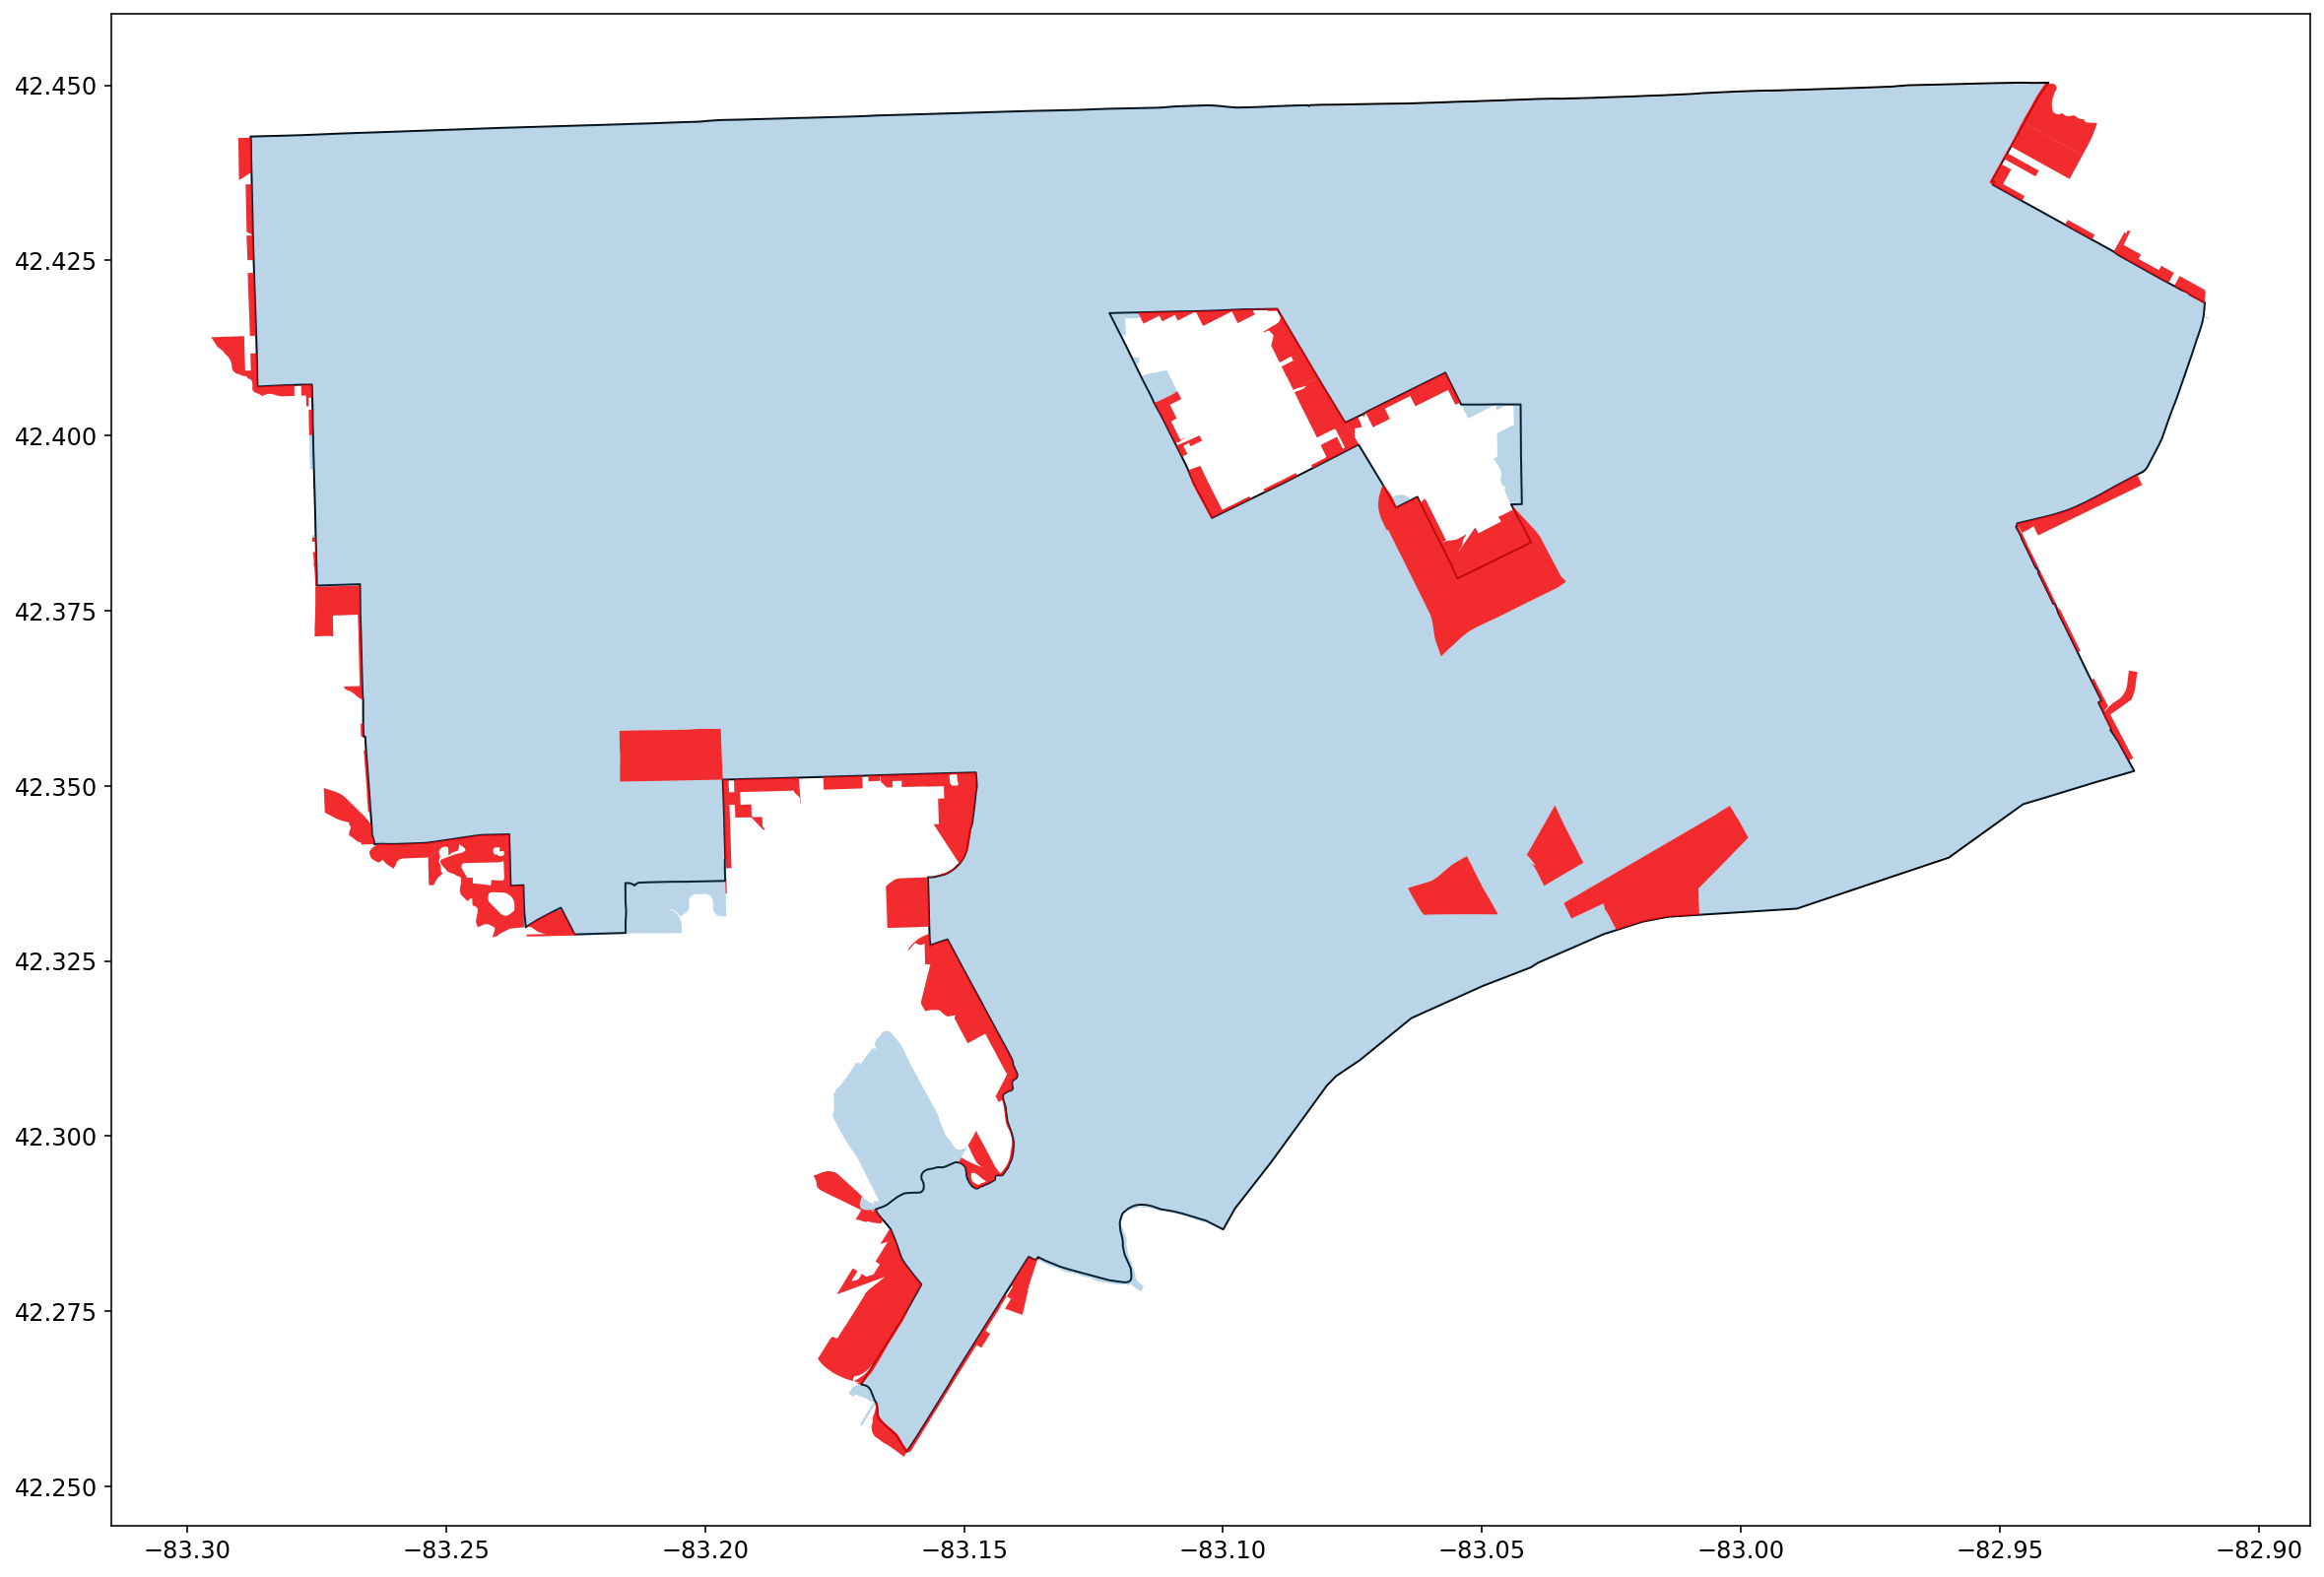

In [123]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
detroit.plot(facecolor='none',ax=ax)
tracts.plot(ax=ax,alpha=0.3)
tracts.loc[(df.population/df.households).dropna().sort_values().head(40).index].plot(ax=ax,color='r',alpha=0.8)
# tracts.loc[lambda x: (x.latitude < 42.325)].plot(ax=ax,alpha=0.3)

<AxesSubplot:>

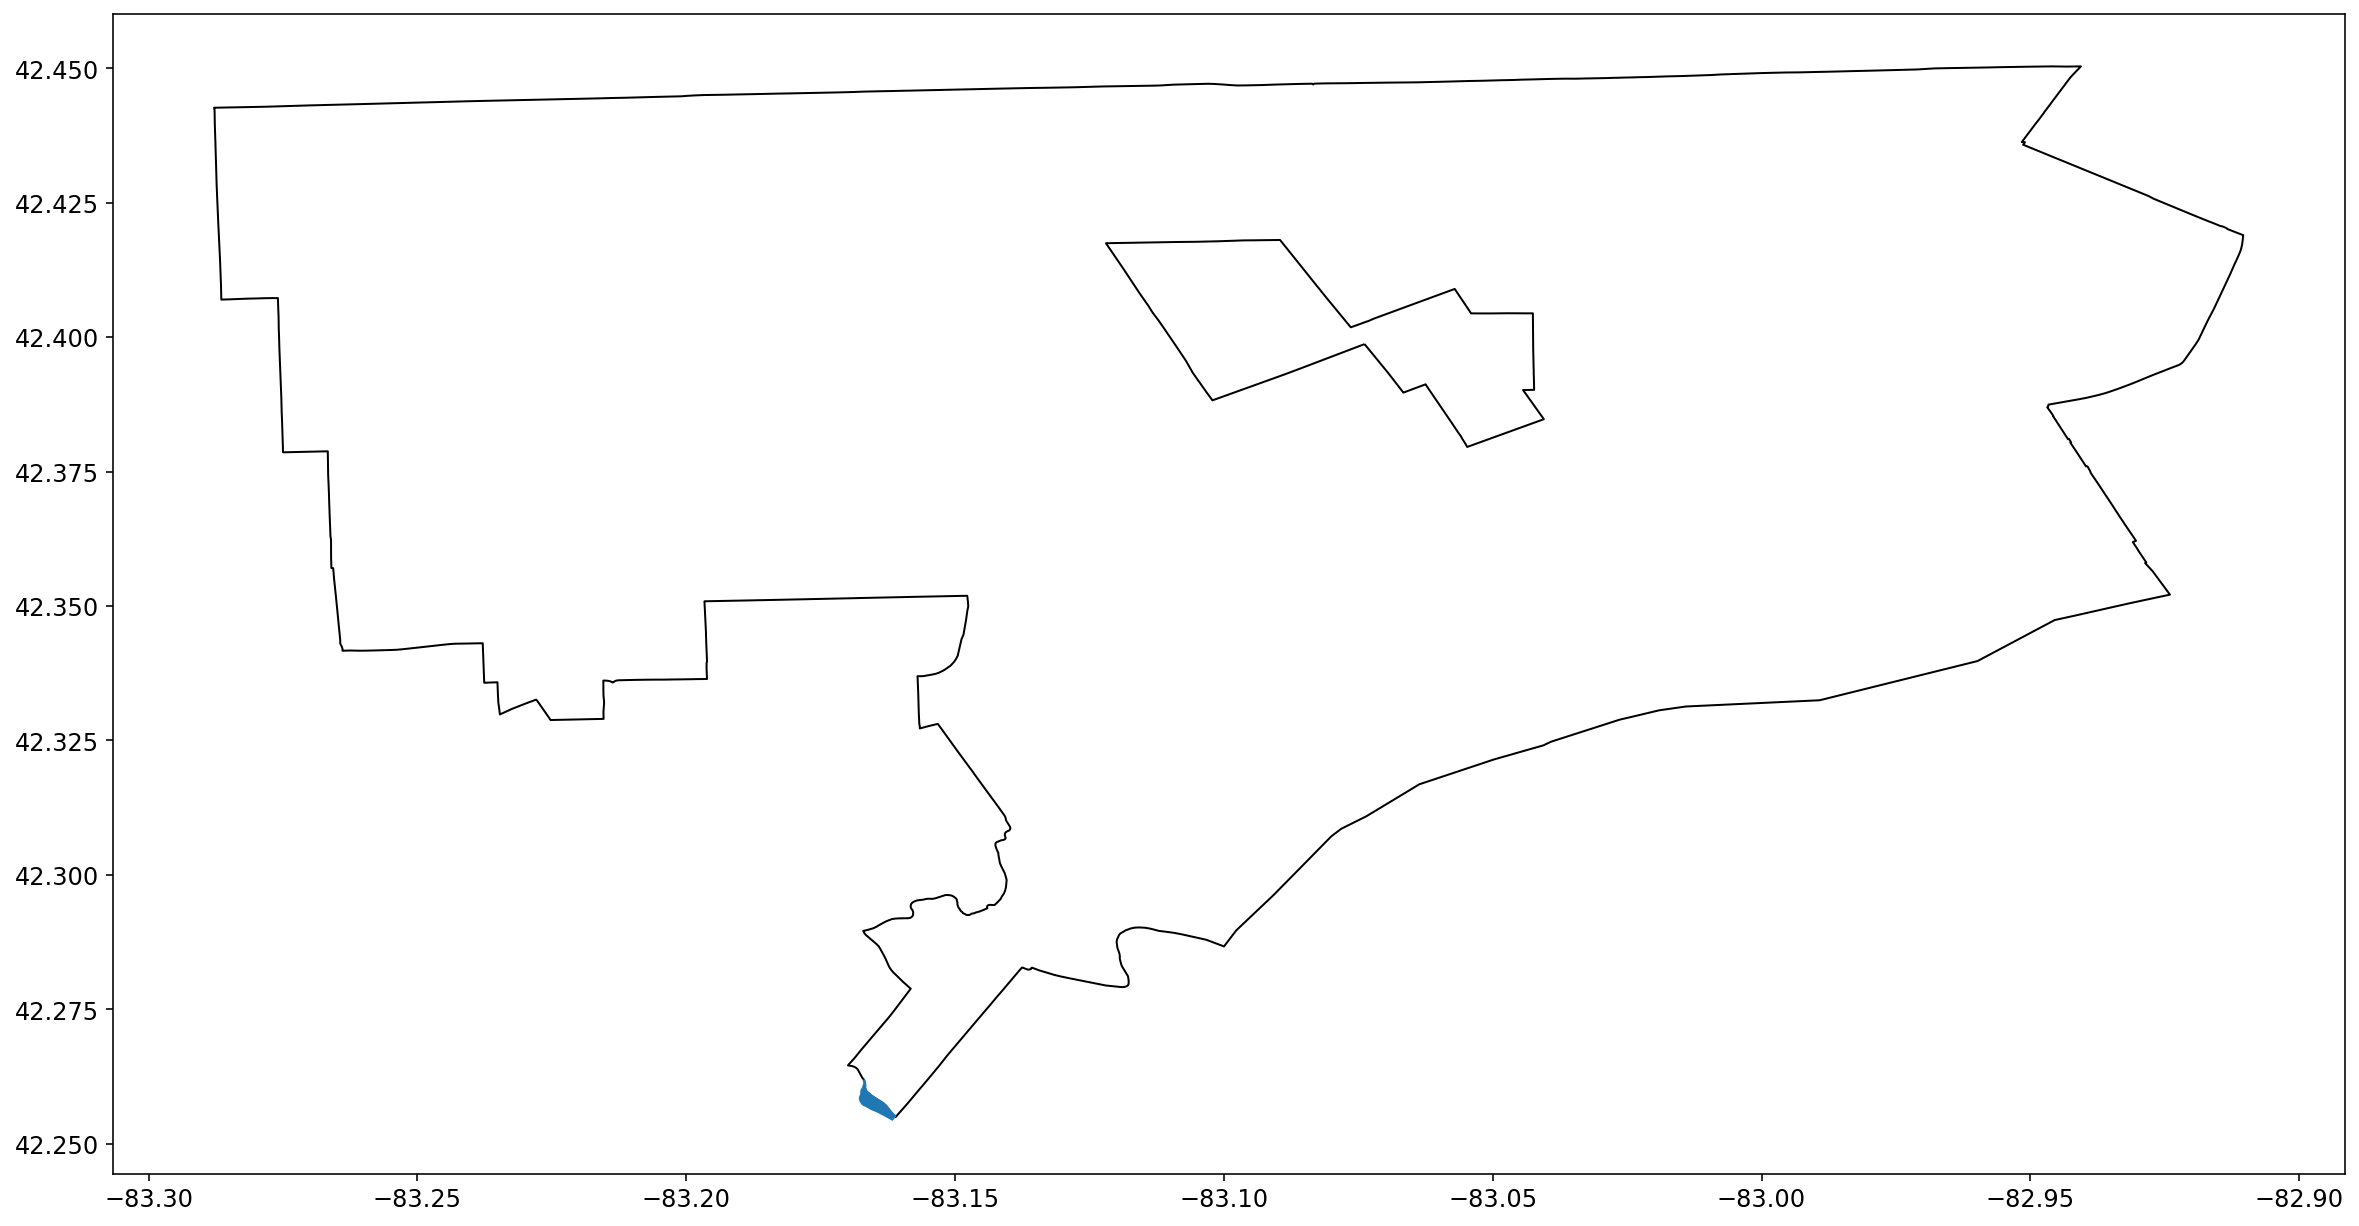

In [77]:
fig,ax=plt.subplots(1,1,figsize=(20,20))
detroit.plot(facecolor='none',ax=ax)
gpd.GeoDataFrame(tracts.loc[df.calls_per_capita.idxmax()].to_frame().T).plot(ax=ax)

In [38]:
df.loc[:,['population','violence_calls']].corr()**2

,population,violence_calls
population,1.000000,0.600627
violence_calls,0.600627,1.000000


In [126]:
tracts.head(1)

,geometry,longitude,latitude
geo_id,,,
2.616350e+10,"POLYGON ((-82.95578 42.43558, -82.95580 42.436...",-82.951065,42.44418


<AxesSubplot:>

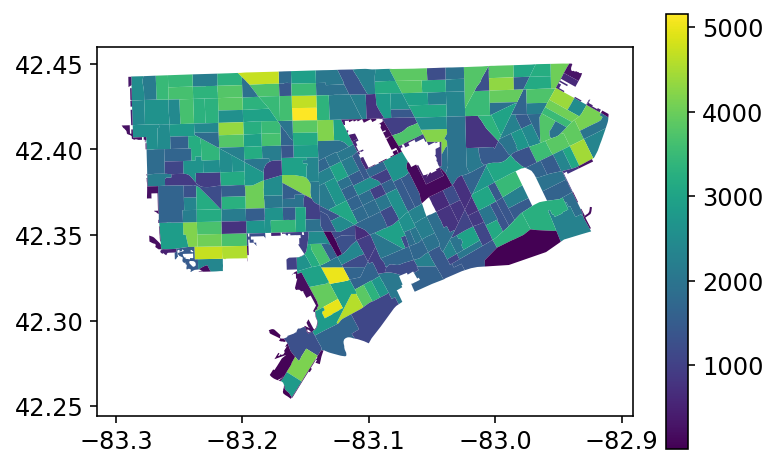

In [132]:
gpd.GeoDataFrame(df.merge(tracts,left_index=True,right_index=True)).plot('population',legend=True)

<AxesSubplot:>

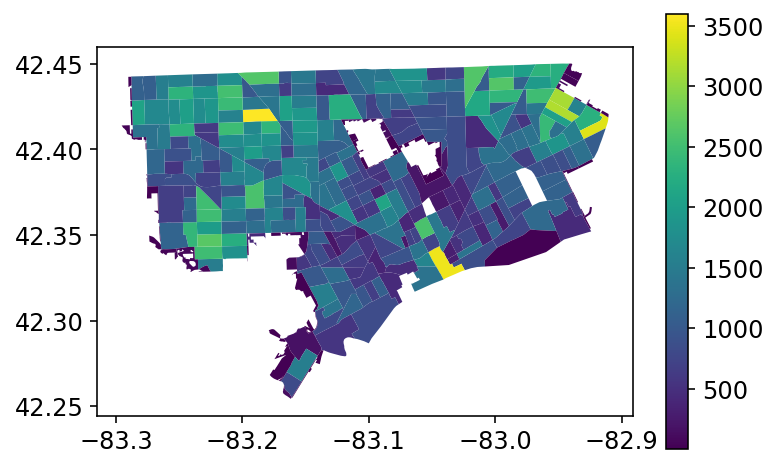

In [131]:
gpd.GeoDataFrame(df.merge(tracts,left_index=True,right_index=True)).plot('violence_calls',legend=True)

$$E[y] = \beta_0 + \beta_1*ln(income) + \beta_2*1/x(poverty rate)$$

$$E[y]=g(\lambda)=$$

In [137]:
des = dmatrix(
    formula_like="""violence_calls + np.log(per_capita_income)
    + per_household_income
    + per_capita_income*per_household_income
    + prop_married_families""",
    data=df.assign(prop_married_families=lambda x: x.married_families/x.households),
    return_type="dataframe",
)

des.head()

,Intercept,violence_calls,np.log(per_capita_income),per_household_income,per_capita_income,per_capita_income:per_household_income,prop_married_families
tract,,,,,,,
2.616350e+10,1.0,2257.0,8.122371,49015.0,3369.0,165131535.0,0.173157
2.616350e+10,1.0,2334.0,7.949444,61980.0,2834.0,175651320.0,0.174632
2.616350e+10,1.0,1948.0,7.549609,50345.0,1900.0,95655500.0,0.075216
2.616350e+10,1.0,1030.0,6.958448,34880.0,1052.0,36693760.0,0.120000
2.616350e+10,1.0,1450.0,7.161622,43058.0,1289.0,55501762.0,0.120553


In [155]:
df.head()

,per_capita_income,per_household_income,households,married_families,non_family_households,population,violence_calls,total_income,new_per_capita_income,calls_per_capita,people_per_household
tract,,,,,,,,,,,
2.616350e+10,3369.0,49015.0,1438,249,674,4032,2257.0,70483570.0,17481.044147,0.559772,2.803894
2.616350e+10,2834.0,61980.0,1088,190,370,3207,2334.0,67434240.0,21027.202993,0.727783,2.947610
2.616350e+10,1900.0,50345.0,811,61,491,3137,1948.0,40829795.0,13015.554670,0.620975,3.868064
2.616350e+10,1052.0,34880.0,375,45,140,1664,1030.0,13080000.0,7860.576923,0.618990,4.437333
2.616350e+10,1289.0,43058.0,506,61,274,2205,1450.0,21787348.0,9880.883447,0.657596,4.357708


In [165]:
des = dmatrix(
    formula_like="""0+violence_calls
    + np.log(per_household_income)
    + prop_married_families
    + population""",
    data=df.assign(prop_married_families=lambda x: x.married_families/x.households),
    return_type="dataframe",
).rename(columns={'np.log(per_household_income)':'log(household income)'})

des.head()

,violence_calls,log(household income),prop_married_families,population
tract,,,,
2.616350e+10,2257.0,10.799882,0.173157,4032.0
2.616350e+10,2334.0,11.034567,0.174632,3207.0
2.616350e+10,1948.0,10.826655,0.075216,3137.0
2.616350e+10,1030.0,10.459669,0.120000,1664.0
2.616350e+10,1450.0,10.670303,0.120553,2205.0


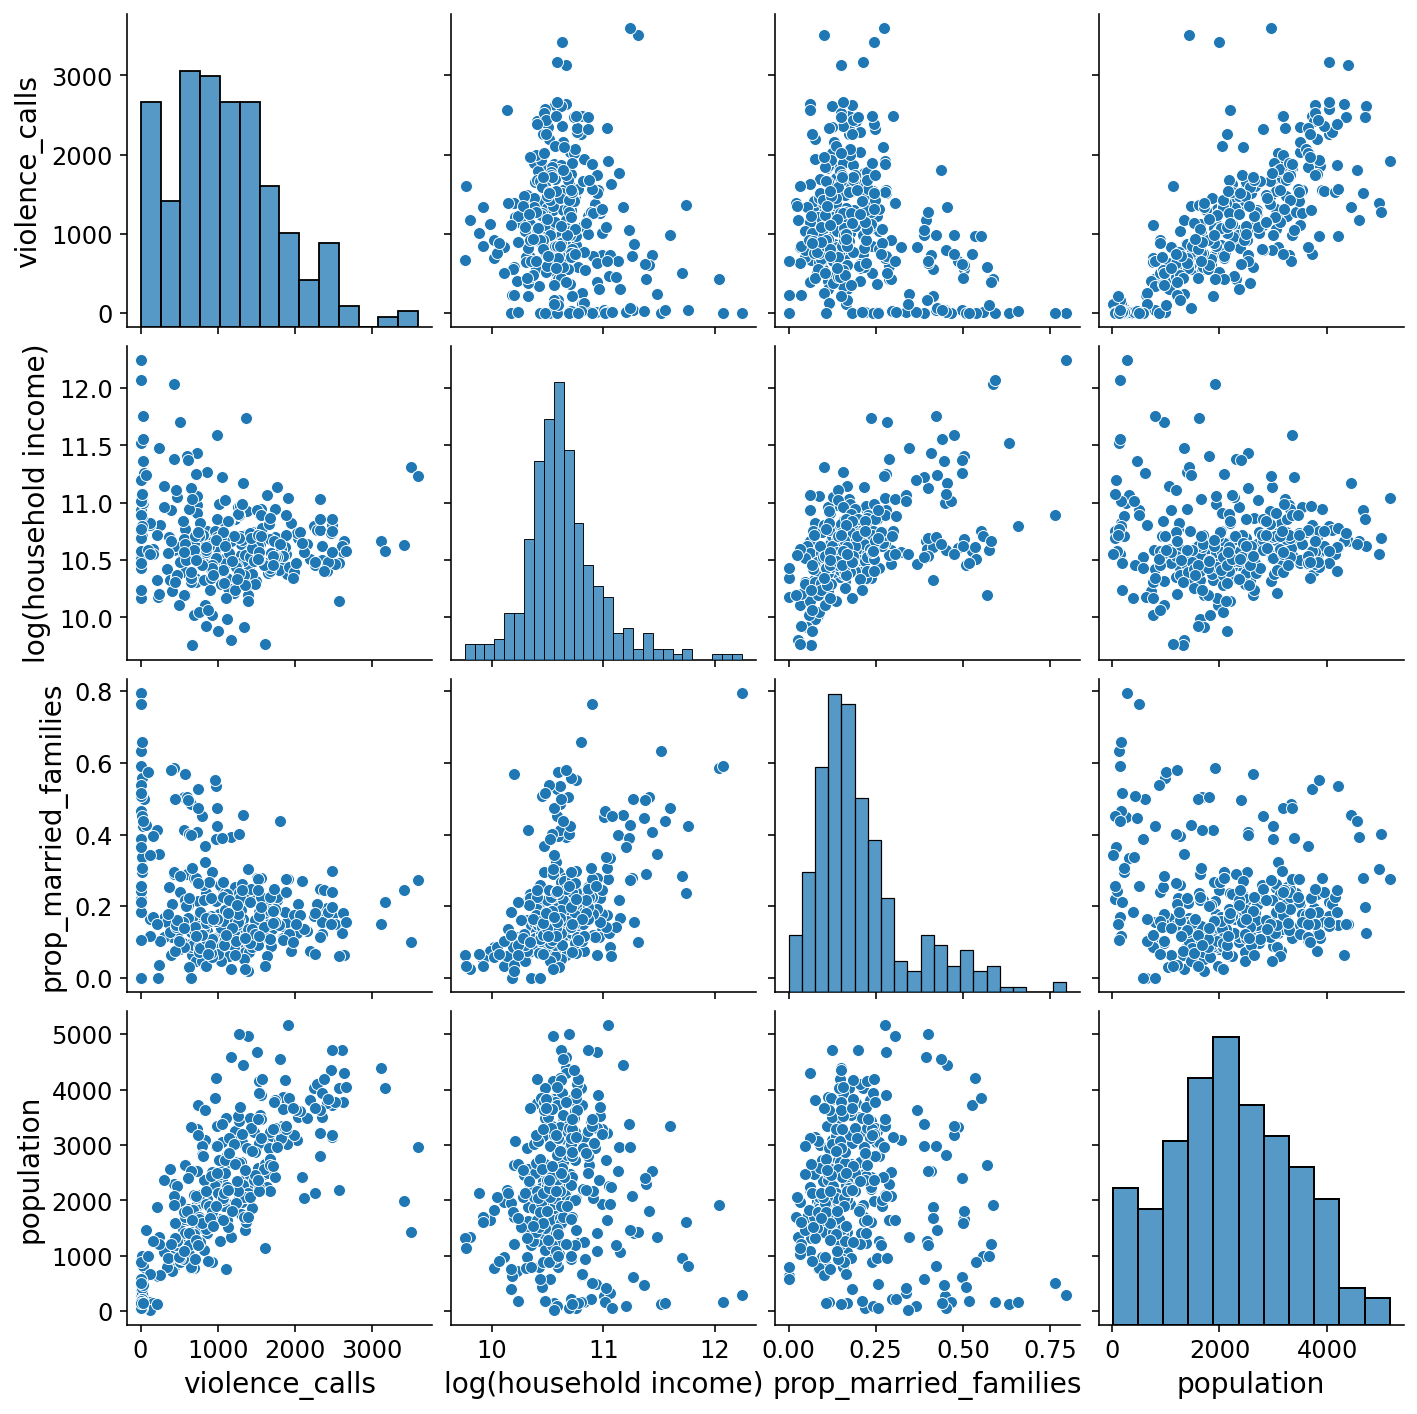

In [166]:
grid = sns.pairplot(des)


In [139]:
y, X = dmatrices(
    formula_like="""violence_calls ~ per_capita_income
    + per_household_income
    + per_capita_income*per_household_income""",
    data=df,
    return_type="dataframe",
)

In [140]:
mdl = sm.GLM(y,X,family=sm.families.Poisson())
res = mdl.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         violence_calls   No. Observations:                  329
Model:                            GLM   Df Residuals:                      325
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -73058.
Date:                Sat, 26 Feb 2022   Deviance:                   1.4337e+05
Time:                        15:37:51   Pearson chi2:                 1.25e+05
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  6.3860      0.011    559.144      0.000       6.364       6.408
per_capita_income                          0.0004   4.32e-06     99.209      0.000       0.000       0.000
per_household_income                    4.513e-06   2.67e-07     16.932      0.000    3.99e-06    5.04e-06
per_capita_income:per_household_income -5.732e-09   9.63e-11    -59.490      0.000   -5.92e-09   -5.54e-09
==========================================================================================================
"""

In [104]:
mdl.data.param_names

['Intercept',
 'per_capita_income',
 'per_household_income',
 'per_capita_income:per_household_income']

In [281]:
sm.graphics.plot_partregress("violence_calls","per_capita_income:per_household_income",["per_household_income","per_capita_income"],data=des,obs_labels=False)
plt.tight_layout()

NameError: name 'des' is not defined

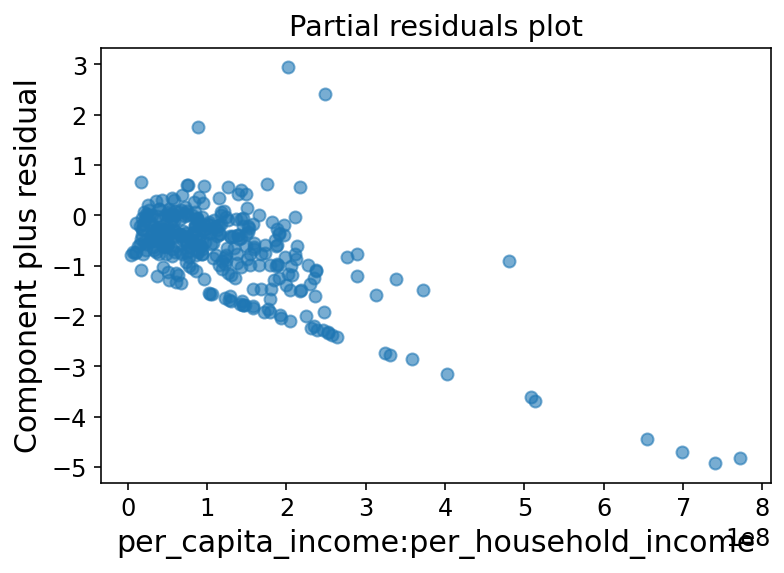

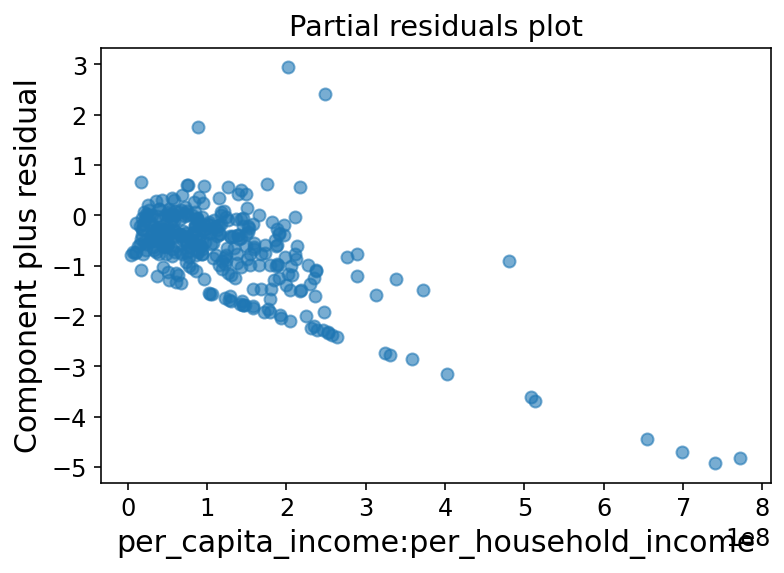

In [105]:
res.plot_partial_residuals('per_capita_income:per_household_income')
# res.plot_partial_residuals('per_household_income')

In [108]:
mdl = sm.OLS(feat_income.dropna().per_capita_income, feat_income.dropna().per_household_income)
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:      per_capita_income   R-squared (uncentered):                   0.693
Model:                            OLS   Adj. R-squared (uncentered):              0.692
Method:                 Least Squares   F-statistic:                              764.3
Date:                Tue, 22 Feb 2022   Prob (F-statistic):                    7.10e-89
Time:                        13:57:49   Log-Likelihood:                         -2972.3
No. Observations:                 340   AIC:                                      5947.
Df Residuals:                     339   BIC:                                      5950.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
per_household_income     0.0429      0.002     27.645      0.000       0.040       0.046
==============================================================================
Omnibus:                       89.254   Durbin-Watson:                   1.256
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.831
Skew:                          -1.026   Prob(JB):                     1.01e-89
Kurtosis:                       7.972   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
mdl = sm.OLS(y,X,)
res = mdl.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         violence_calls   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     33.03
Date:                Tue, 22 Feb 2022   Prob (F-statistic):           7.99e-14
Time:                        13:45:03   Log-Likelihood:                -2685.9
No. Observations:                 339   AIC:                             5378.
Df Residuals:                     336   BIC:                             5389.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1002.2248     95.872     10.454      0.000     813.639    1190.810
per_capita_income        0.2013      0.030      6.662      0.000       0.142       0.261
per_household_income    -0.0089      0.001     -6.039      0.000      -0.012      -0.006
==============================================================================
Omnibus:                       19.104   Durbin-Watson:                   0.862
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.353
Skew:                           0.326   Prob(JB):                     2.11e-08
Kurtosis:                       4.441   Cond. No.                     1.40e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

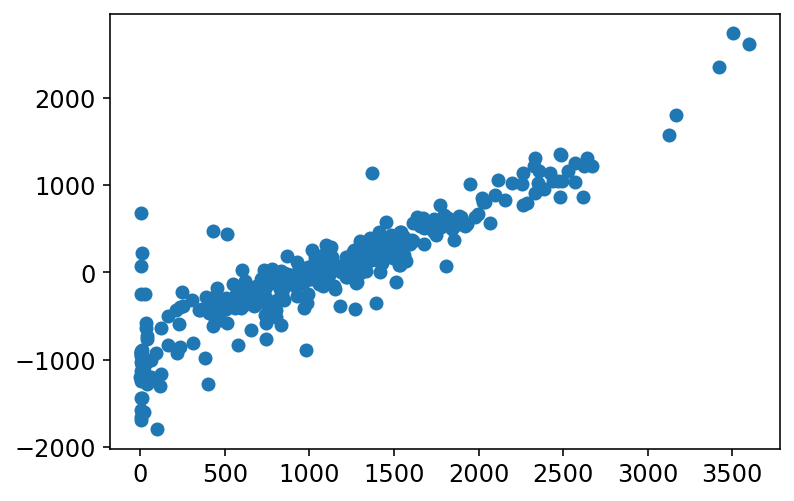

In [95]:
plt.scatter(y,res.resid)

In [40]:
raw = pd.read_csv('population/DECENNIALPL2010.P1_data_with_overlays_2022-02-06T092022.csv',usecols=['GEO_ID','P001001'],skiprows=[1])

In [59]:
rawish = raw.loc[raw.P001001.str.contains('\(')].assign(population=lambda x: x.P001001.str.split('(').apply(lambda x: x[0])).astype({'population':int})

In [62]:
rawish.population

89        69
94         8
107       27
108        0
171       37
        ... 
6178       4
6184       3
6377      75
10100    175
13562      8
Name: population, Length: 276, dtype: int64